<h1><center>Case Study - B3</center></h1>

# Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

In [2]:
# loading df_cleaned and resetting Dtypes
df = pd.read_csv("df_cleaned.csv")
df['id_cliente']=df['id_cliente'].astype(str)
df[['renda', 'profissao']] = df[['renda', 'profissao']].astype('category')

|Nome          |Período|Unidade|Descrição                        |
|:-------------|-----  |------|--------------------------------- |
|id_cliente    |N/A    |N/A   |Id único que identifica cliente   |
|renda         |N/A    |R\$   |Faixa de renda declarada          |
|profissao     |N/A    |N/A   |Grupo de profissões agrupadas     |
|qt_compras    |M0     |ativos|Quantidade de ativos adquiridos   |
|val_compra    |M0     |R\$    |Valor total das ações compradas   |
|tm_compra     |M0     |R\$   |Valor por ação - compra (“ticket”)|
|qt_vendas     |M0     |ativos|Quantidade de ativos vendidos    |
|val_venda     |M0     |R\$    |Valor total das ações vendidas    |
|tm_venda      |M0     |R\$    |Valor por ação - venda (“ticket”) |
|dif_cv        |M0     |ativos |Diferença entre compra e venda de ativos     |
|acoes         |M0     |#     |# ações na carteira               |
|acoes_dif     |M0     |#     |# ações diferentes na carteira    |
|ativo_m1      |M1     |Flag  |1=Cliente está ativo em M1        |
|ligou_cr_m1   |M1     |Flag  |1=Contato na central em M1        |

Although exploratory analysis provides some interesting indicators, we can raise the bar in our analysis with machine learning models to see which features help predict the variable that matters in our case: **ativo_m1**.

In other words, how can we determine whether a customer is about to leave next month, to optimize the work of customer relationship managers (and offer reduced prices, if that's the case) without unnecessarily inconveniencing others?

Next, I will use two forecasting techniques: **Logistic Regression** and **Random Forest**.

Logistic Regression is useful for being able to work with continuous and discrete data. However, unlike Linear Regression, it is not easy to compare performance of models with many vs. few independent variables (there is no concept of residuals, so it is not possible to use the least squares (cost function) to calculate the R²) - For this, we test whether the effect of the independent variable in predicting the dependent is significantly different from 0 ( using Wald's Test, or Z test - I didn't use Chi-square). If not (=0), it means the variable is not helping. In other words, we use the concept of 'maximum likelihood' (we calculate the observation probability of all points on the X axis to be y=0 and y=1 (Sigmoid function converts the input into a range 0-1), and we multiply all the probabilities/likelihood together; then we move the "S" line several times and calculate the same thing until we find the curve with 'maximum likelihood'). To do this, we calculate the probability of leaving the brokerage house by the total number of people who left the brokerage house divided by the total number of customers. Then we multiply this probability by the total number of customers who have a specific independent variable. This will be the expected number of clients that have the independent variable AND have left the broker. And the rest is the expected number of clients that have the independent variable E will not leave the broker. Then we do the same (probability of leaving the broker (already calculated) x total number of clients who DO NOT have this same independent variable (and subtraction).

First of all, we need to turn categorical variables into dummy variables - binary "switches" that turn the parameters in the equation on or off.

##### Creating dummy variables

In [3]:
cat_features = ['renda','profissao'] # the categorical features

df_dummy = pd.get_dummies(df, columns = cat_features)
df_dummy.drop(['id_cliente','ligou_cr_m1'], axis=1, inplace=True) # leaving only independent variables

df_dummy.head()

,qt_compras,val_compra,tm_compra,qt_vendas,val_venda,tm_venda,dif_cv,acoes,acoes_dif,ativo_m1,renda_De 0 a 5k,renda_De 10 a 15k,renda_De 15 a 20k,renda_De 5 a 10k,profissao_A,profissao_B,profissao_C
0,0.0,0.00,0.0,100.01,2941.26,29.41,-100.01,9900,40,True,1,0,0,0,0,1,0
1,0.0,0.00,0.0,599.90,9388.48,15.65,-599.90,7800,20,True,0,0,0,1,1,0,0
2,0.0,0.00,0.0,0.00,0.00,0.00,0.00,1600,5,False,1,0,0,0,1,0,0
3,0.0,0.00,0.0,400.08,4488.88,11.22,-400.08,7200,30,True,0,0,0,1,0,0,1
4,200.0,3340.07,16.7,199.98,4143.59,20.72,0.02,4400,10,True,0,0,0,1,0,1,0


We also need to separate test data from training data so as not to have a complex model with a very good fit with the data, as it may not be generalist enough to work with new data (overfitting)

In [4]:
X = df_dummy.loc[:, df_dummy.columns != 'ativo_m1']
y = df_dummy.loc[:, df_dummy.columns == 'ativo_m1']

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

As we saw in the exploratory analysis, classes are unbalanced (89/11).

One way to resolve unbalanced datasets is "oversample" the smaller class. That
One approach to addressing imbalanced datasets is to oversmple the minority class. The simplest approach involves duplicating examples in the minority class, although these examples do not add any new information to the model. Instead, new examples can be synthesized from existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE.

At a high level, SMOTE works by creating synthetic secondary class samples (unsigned) rather than creating copies.
Randomly choosing one of the nearest k-nearest-neighbors and using it to create new observations similar but randomly adjusted.

In [5]:
os = SMOTE(random_state = 0)

os_df_X, os_df_y = os.fit_sample(X_train, y_train)
os_df_X = pd.DataFrame(data = os_df_X, columns = columns)
os_df_y = pd.DataFrame(data = os_df_y, columns = ['ativo_m1'])

We need to round up because logistic regression gives error with infinite floats: *ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals*

In [6]:
os_df_X = os_df_X.round()
os_df_y = os_df_y.round()

In [7]:
# checking the distribution of datasets after SMOTE

print("Size of the oversampled data is ", len(os_df_X))
print("Number of clients who left the broker in M1 is ", len(os_df_y[os_df_y['ativo_m1'] == False]))
print("Number of customers who continued with the broker in M1 is", len(os_df_y[os_df_y['ativo_m1'] == True]))
print("Proportion of customers who left in M1 in the oversampled data is of ", len(os_df_y[os_df_y['ativo_m1'] == 0]) / len(os_df_X))
print("Proportion of customers who continued in M1 in the oversampled data is ", len(os_df_y[os_df_y['ativo_m1'] == 1]) / len(os_df_X))

Size of the oversampled data is  12436
Number of clients who left the broker in M1 is  6218
Number of customers who continued with the broker in M1 is 6218
Proportion of customers who left in M1 in the oversampled data is of  0.5
Proportion of customers who continued in M1 in the oversampled data is  0.5


We now have balanced data.

I decided to apply SMOTE only to the training data (X_train, y_train) because, that way, no information from the test data is being used to create synthetic observations - that is, no information will come out of the test data for model training.

## Logistic Regression - initial analysis

In [8]:
X = os_df_X
y = os_df_y['ativo_m1']

import statsmodels.api as sm
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.301415
         Iterations 10
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.565    
Dependent Variable:   ativo_m1         AIC:              7528.7849
Date:                 2021-07-14 15:56 BIC:              7647.6385
No. Observations:     12436            Log-Likelihood:   -3748.4  
Df Model:             15               LL-Null:          -8620.0  
Df Residuals:         12420            LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       10.0000                                     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
qt_compras         0.5759   0.7406   0.7775 0.4368 -0.8758  2.0275
val_compra         0.0002   0.0001   3.1933 0.0014  

25% of p-values are statistically insignificant - let's try to improve this:

#### Feature selection

In this study, I will use **Recursive Feature Elimination**, **Decision Trees** and the **VIF** method to eliminate multicollinearity and arrive at the most important features in predicting the independent variable **ativo_m1**.

##### Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea of repeatedly creating a model and choosing which one has the best feature performance, leaving the feature aside and repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal is to select features by considering recursively smaller and smaller amounts of variables.

In [9]:
logreg = LogisticRegression(solver='liblinear', max_iter=100)

rfe = RFE(logreg, n_features_to_select=1)
rfe = rfe.fit(os_df_X, os_df_y.values.ravel())

print(rfe.support_)
order = rfe.ranking_ - 1
order

[False False False False False False False False False False False False
 False  True False False]


array([ 9, 15,  7, 11, 13, 12, 10, 14,  8,  6,  4,  3,  5,  0,  2,  1])

Ordering, to improve the visualization:

In [10]:
feature_rank = []
for i in order:
    feature_rank.append(f"{i}. {os_df_X.columns[i]}")
feature_rank

['9. renda_De 0 a 5k',
 '15. profissao_C',
 '7. acoes',
 '11. renda_De 15 a 20k',
 '13. profissao_A',
 '12. renda_De 5 a 10k',
 '10. renda_De 10 a 15k',
 '14. profissao_B',
 '8. acoes_dif',
 '6. dif_cv',
 '4. val_venda',
 '3. qt_vendas',
 '5. tm_venda',
 '0. qt_compras',
 '2. tm_compra',
 '1. val_compra']

It is interesting to note that information on purchases and sales (quantity, values and average ticket) is more important in predicting y - but must have high collinearity.

##### Decision Trees

Decision trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from data resources. A tree can be seen as a constant approximation in parts.

A tree is built by dividing the source set, constituting the root node of the tree, into subsets - which constitute the successor children. Division is based on a set of division rules based on classification characteristics. This process is repeated on each derived subset in a recursive manner called recursive partitioning. Recursion is completed when the subset within a node has all the same target variable values, or when the split no longer adds value to the predictions.

Official document: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [11]:
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10) # entropy = criterion for calculating information gain / random_state = random number generator
dt.fit(os_df_X,os_df_y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [12]:
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(os_df_X):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for qt_compras is : 0.3286770895369566
The feature importance for val_compra is : 0.010070407356842545
The feature importance for tm_compra is : 0.0032020566669006723
The feature importance for qt_vendas is : 0.38968738902194006
The feature importance for val_venda is : 0.002800062240591695
The feature importance for tm_venda is : 0.010548456945992076
The feature importance for dif_cv is : 0.01646783079208373
The feature importance for acoes is : 0.028911234926423047
The feature importance for acoes_dif is : 0.10514926838412052
The feature importance for renda_De 0 a 5k is : 0.0003785305386830202
The feature importance for renda_De 10 a 15k is : 0.0008295703973727613
The feature importance for renda_De 15 a 20k is : 0.0
The feature importance for renda_De 5 a 10k is : 0.002192014644367496
The feature importance for profissao_A is : 0.07122563745918158
The feature importance for profissao_B is : 0.019527249469957167
The feature importance for profissao_C is : 0.01

Ordering, to improve the visualization:

In [13]:
# Creating a Dataframe
fi_dt = zip(fi_col, fi)
fi_dt = pd.DataFrame(fi_dt, columns = ['Feature','Feature Importance'])

# Sorting the data
fi_dt = fi_dt.sort_values('Feature Importance', ascending = False).reset_index()

fi_dt

,index,Feature,Feature Importance
0,3,qt_vendas,0.389687
1,0,qt_compras,0.328677
2,8,acoes_dif,0.105149
3,13,profissao_A,0.071226
4,7,acoes,0.028911
5,14,profissao_B,0.019527
6,6,dif_cv,0.016468
7,5,tm_venda,0.010548
8,15,profissao_C,0.010333
9,1,val_compra,0.010070


The quantities of purchases and sales remain at the top, as in the case of the RFE, but information regarding actions and professions also appears.

Multicollinearity is also an issue for Decision Trees. Decision trees make no assumptions about the relationships between resources. It just builds divisions on single features that improve rank, based on a measure of impurity like Gini or entropy. If the resources *qt_vendas* and *tm_venda* are strongly correlated, no / little information can be obtained from the division into *tm_venda* after the division into *qt_vendas*. In the case of multicollinearity, this will likely mean that they will fit the most effective variable they find, leaving out other plausible variables. There is a material probability that the algorithm fits not on the 'right' variable, but on a strong variable correlated with the right variable, since which predictor is chosen to partition the samples is essentially a random selection.

##### Multicollinearity & VIF technique

Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation with each other. When some features are highly correlated, we may have difficulty distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using several techniques, one of which is the Variance Inflation Factor (VIF).
​
In the VIF method, we pick each feature and regress it against all other features.

In [14]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = os_df_X.columns

# calculando VIF para cada feature
vif_data["VIF"] = [variance_inflation_factor(os_df_X.values, i)
                          for i in range(len(os_df_X.columns))]
  
print(vif_data)

              feature           VIF
0          qt_compras  4.380152e+07
1          val_compra  1.619987e+01
2           tm_compra  3.591717e+00
3           qt_vendas  4.501439e+07
4           val_venda  1.490042e+01
5            tm_venda  3.648959e+00
6              dif_cv  4.618898e+07
7               acoes  6.139464e+00
8           acoes_dif  4.391648e+00
9     renda_De 0 a 5k  2.655966e+00
10  renda_De 10 a 15k  2.410159e+00
11  renda_De 15 a 20k  2.078291e+00
12   renda_De 5 a 10k  2.324807e+00
13        profissao_A  2.157061e+00
14        profissao_B  2.113511e+00
15        profissao_C  2.154427e+00


As a rule, a VIF greater than 2 already indicates multicollinearity.

To choose the features, I used a combination of:
- Variables that were detected as important in both RFE and Decision Trees (qt_vendas, qt_compras, acoes_dif, renda e profissão))
- Categorical variables that showed a trend in the Exploratory Analysis (renda e profissão)) and can give important signals in the approach of Customer Relationship agents
- Elimination of features with high multicollinearity

##### Testing Multicollinearity

In [15]:
cols_reduced = ['renda_De 0 a 5k', 
        'renda_De 10 a 15k', 
        'renda_De 15 a 20k',
        'renda_De 5 a 10k',
        'profissao_A',
        'profissao_B',
        'profissao_C', 
        'qt_vendas', 
        'qt_compras',
        'acoes_dif']

X_reduced = os_df_X[cols_reduced]
y_reduced = os_df_y['ativo_m1']
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i)
                          for i in range(len(X_reduced.columns))]
  
print(vif_data)

             feature       VIF
0    renda_De 0 a 5k  2.185256
1  renda_De 10 a 15k  2.166856
2  renda_De 15 a 20k  1.833100
3   renda_De 5 a 10k  2.130369
4        profissao_A  2.082712
5        profissao_B  2.029286
6        profissao_C  2.069068
7          qt_vendas  1.817082
8         qt_compras  1.840882
9          acoes_dif  2.318576


There was a significant improvement, now we go to logistic regression:

## Logistic Regression - final analysis

In [16]:
import statsmodels.api as sm
logit_model = sm.Logit(y_reduced,X_reduced)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.348541
         Iterations 9
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.497    
Dependent Variable:   ativo_m1         AIC:              8688.9183
Date:                 2021-07-14 15:56 BIC:              8763.2018
No. Observations:     12436            Log-Likelihood:   -4334.5  
Df Model:             9                LL-Null:          -8620.0  
Df Residuals:         12426            LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       9.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
renda_De 0 a 5k   -2.4259   0.0639 -37.9457 0.0000 -2.5512 -2.3006
renda_De 10 a 15k -0.6060   0.1197  -5.0614 0.0000 -0

### Comments:

- Pseudo R-squared: explaining almost 50% of the variation in *ativo_m1* (although it is not the ideal indicator, as R² in the OLS - here it is the ratio of the logarithmic probability of the null model to the full model.)
- The Z-test (ratio of Coef/Std.Err) is a way of testing whether the effect of the independent variable in predicting the dependent variable is significantly different from 0.
- Coefficients predict changes in log odds of the dependent variable for each unit augmented in the independent variable. Positive values ​​indicate that an increase in the explanatory variable also predicts an increase in the probability associated with the dependent variable. For example, when the customer has *profissao_A* (changes from 0 to 1), the cumulative probability of the customer being active (changes from 0 to 1) increases by exp(1,6007) - with 95% confidence interval of being between 1.4236 - 1.7778.
- Negative coefficients indicate the opposite: for example, when the customer has *renda_De 0 a 5k* (changes from 0 to 1), the cumulative probability of the customer being active (changes from 0 to 1) reduces exp(2.4259) - with 95 % confidence interval lies between -2.5512 - -2.3006.


That said, we can see that:
- The lower the income, the greater the likelihood of ativo_m1 = 0 (leaving the broker in M1). Especially if it's less than 10K. Proving deductions from the exploratory analysis and indicating that the problem may be that lower-income customers are looking for more competitive prices;
- Professions B and C are more likely to leave the brokerage house, also proving deductions from the exploratory analysis;
- Quantity of assets bought and sold do not have significant difference in the forecast of ativo_m1. In the exploratory analysis, "having sold more assets than bought is not necessarily a good indicator that the client exited in M1 (mean dif_cv smaller/negative)"
- Having a larger amount of different stocks does not explain ativo_m1 forecast significantly either. In the exploratory analysis: "clients who remained in M1 have an average of # different shares and generally higher than clients who left, but there are outliers in active clients in M1 that pull the average up"

#### Predicting Test Sets and Calculating Accuracy

Accuracy is the ratio of correct predictions to total predictions.

In [17]:
# using scikit-learn LogisticRegression (applies regularization)
# By default, scikit-learn‘s logistic regression applies regularization (e por isso pode ser diferente do statsmodel Logit). Regularization balances the need for predictive accuracy on the training data with a penalty on the magnitude of the model coefficients. Increasing the penalty reduces the coefficients and hence reduces the likelihood of overfitting. If the penalty is too large, though, it will reduce predictive power on both the training and test data. We can set turn off regularization by setting penalty as none.
logreg = LogisticRegression(solver='liblinear', max_iter=100)
logreg.fit(X_reduced, y_reduced.values.ravel())

LogisticRegression(solver='liblinear')

In [18]:
X_test_reduced = X_test[cols_reduced]
y_test_reduced = y_test['ativo_m1']

y_pred = logreg.predict(X_test_reduced)
print('Accuracy of logistic regression in test set: {:.2f}'.format(logreg.score(X_test_reduced, y_test_reduced)))

Accuracy of logistic regression in test set: 0.93


Model accuracy: 93%

#### Confusion Matrix

array([[ 279,   41],
       [ 170, 2510]], dtype=int64)

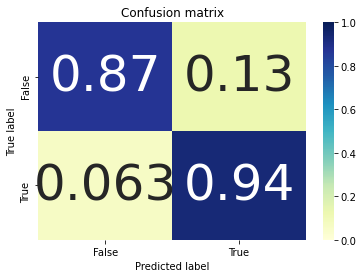

In [19]:
# Viewing Confusion Matrix
cm = confusion_matrix(y_test_reduced, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1) # each line divided by the sum of the line (percent)

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plota um Confusion Matrix"""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm_norm, classes = logreg.classes_, title='Confusion matrix')
cm

The result tells us that there were 279 (87% of the y's that were negative and the model predicted as negative) + 2510 (94% of the y's that were positive and we predicted as positive). A total of 2789 correct predictions, against 41+170=211 incorrect predictions.

#### Compute precision, recall, F-measure and support

Quoting Scikit Learn:

Precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp is the number of false positives. Precision is intuitively the classifier's ability not to label a sample as positive if it is negative.

Recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. Recall is intuitively the classifier's ability to find all positive samples.

The F-beta score can be interpreted as a harmonic weighted average of accuracy and recall, where an F-beta score reaches its best value of 1 and the worst score of 0.

The F-beta score weights recall more than accuracy by a beta factor. beta = 1.0 means that recall and accuracy are equally important.

Support is the number of occurrences of each class in y_test.

In [20]:
print(classification_report(y_test_reduced, y_pred))

              precision    recall  f1-score   support

       False       0.62      0.87      0.73       320
        True       0.98      0.94      0.96      2680

    accuracy                           0.93      3000
   macro avg       0.80      0.90      0.84      3000
weighted avg       0.95      0.93      0.93      3000



#### ROC curve

A ROC (Receiver Operating Characteristic) curve is a graph that shows the performance of a classification model across all classification thresholds. This curve represents two parameters: True Positive Rate and False Positive Rate.

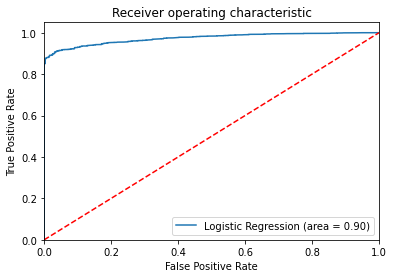

In [21]:
logit_roc_auc = roc_auc_score(y_test_reduced, logreg.predict(X_test_reduced))
fpr, tpr, thresholds = roc_curve(y_test_reduced, logreg.predict_proba(X_test_reduced)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The dotted line represents the ROC curve of a purely random classifier. Classifiers that provide curves closer to the upper left corner indicate better performance. As a baseline, a random classifier is expected to provide points along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

# Random Forest

Random Forest is one of the most popular "ensemble" methods for supervised machine learning and is capable of performing both regression and classification.

RF develops a “forest” by building a multitude of decision trees. Because of its Bootstrap Aggregation and Feature Randomness algorithms, Random Forests can handle large data sets and numerical and categorical variables with high dimensionality, without overfitting (unlike a regular decision tree) or needing to be standardized (Hastie, et al., 2009). Furthermore, by using a random subset of variables, it reduces the correlations in the tree (Breiman, 2001), producing a more accurate prediction (Ho, 1995) and avoiding multicollinearity of features.

Due to its mixed method of Bootstrap Aggregation with Feature Randomness, it is possible to measure the importance of each feature, as well as estimate the strength of the ensemble, correlation and generalization error (PE) in each division of the tree, allowing the model to be adjusted and validated during training (Breiman, 2001; Hastie, Tibshirani, & Friedman, 2009).

In summary, it is a very simple and complete "out of the box" algorithm.

The number of 100 decision trees was defined for the set as n_estimators.

In [22]:
forest_clas = RandomForestClassifier(n_estimators=100)
forest_clas.fit(os_df_X, os_df_y) # training

predictions = forest_clas.predict(os_df_X)
forest_mse = mean_squared_error(os_df_y, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

<ipython-input-22-4e3dee9c2517>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_clas.fit(os_df_X, os_df_y) # training


0.03233190689212125

Typical error of 0.03 with Random Forest Classifier. Even better than Logistic Regression.

In [23]:
print(classification_report(os_df_y,predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6218
        True       1.00      1.00      1.00      6218

    accuracy                           1.00     12436
   macro avg       1.00      1.00      1.00     12436
weighted avg       1.00      1.00      1.00     12436



In [24]:
features = df_dummy.loc[:, df_dummy.columns != 'ativo_m1']

print("Features ordenadas pelo score:")
print(sorted(zip(map(lambda x: float("{0:.5f}".format(round(x, 4))), forest_clas.feature_importances_), features),
             reverse=True))

Features ordenadas pelo score:
[(0.1695, 'qt_vendas'), (0.1568, 'qt_compras'), (0.1229, 'val_compra'), (0.1135, 'acoes_dif'), (0.0972, 'val_venda'), (0.0812, 'dif_cv'), (0.079, 'acoes'), (0.0499, 'profissao_A'), (0.0497, 'tm_venda'), (0.0449, 'tm_compra'), (0.0092, 'renda_De 5 a 10k'), (0.0075, 'profissao_C'), (0.006, 'profissao_B'), (0.0053, 'renda_De 0 a 5k'), (0.0047, 'renda_De 10 a 15k'), (0.0027, 'renda_De 15 a 20k')]


Random Forest Classifier confirms the suggestion of the most important features of Features Extraction and Exploratory Analysis: *qt_compras*, *qt_vendas* e *acoes_dif*, in addition to *profissao_A* and *renda_De 5 to 10k*, despite their reduced importance.